In [3]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [4]:
print("[INFO] Loading images...")
imgL = cv2.imread("1.jpg")
imgR = cv2.imread("2.jpg")
print(" - Left image shape:", imgL.shape)
print(" - Right image shape:", imgR.shape)

[INFO] Loading images...
 - Left image shape: (480, 640, 3)
 - Right image shape: (480, 640, 3)


In [5]:
def preprocess(im, target_h=None, name=""):
    print(f"[INFO] Preprocessing {name} image...")
    if target_h is not None and im.shape[0] != target_h:
        scale = target_h / im.shape[0]
        im = cv2.resize(im, (int(im.shape[1]*scale), target_h), interpolation=cv2.INTER_AREA)
        print(f"   - Resized {name} image to:", im.shape)

    im = cv2.fastNlMeansDenoisingColored(im, None, 3, 3, 7, 21)
    print(f"   - Denoised {name}")

    lab = cv2.cvtColor(im, cv2.COLOR_BGR2LAB)
    L, A, B = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    L = clahe.apply(L)
    lab = cv2.merge([L, A, B])
    im = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
    print(f"   - Applied CLAHE on {name}")

    plt.figure()
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
    plt.title(f"Preprocessed {name}")
    plt.axis("off")
    plt.show()

    return im

[INFO] Preprocessing Left image...
   - Resized Left image to: (600, 800, 3)
   - Denoised Left
   - Applied CLAHE on Left


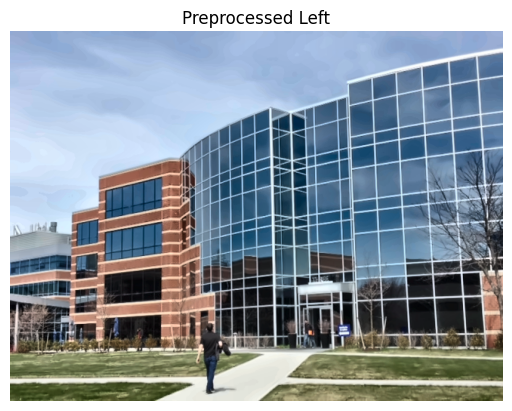

[INFO] Preprocessing Right image...
   - Resized Right image to: (600, 800, 3)
   - Denoised Right
   - Applied CLAHE on Right


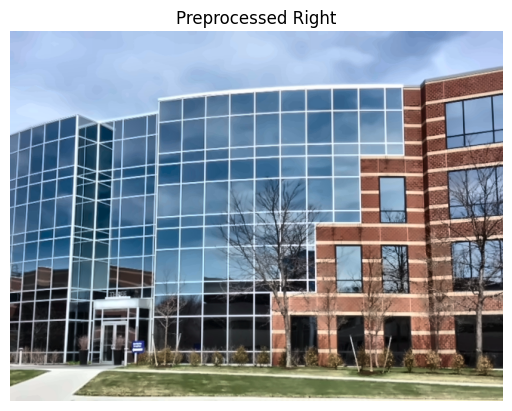

In [6]:
# Preprocess images
target_h = 600
imgL_p = preprocess(imgL, target_h, "Left")
imgR_p = preprocess(imgR, target_h, "Right")

In [7]:
print("[INFO] Detecting SIFT features...")
sift = cv2.SIFT_create()
kL, dL = sift.detectAndCompute(cv2.cvtColor(imgL_p, cv2.COLOR_BGR2GRAY), None)
kR, dR = sift.detectAndCompute(cv2.cvtColor(imgR_p, cv2.COLOR_BGR2GRAY), None)
print(" - Keypoints Left:", len(kL))
print(" - Keypoints Right:", len(kR))

[INFO] Detecting SIFT features...
 - Keypoints Left: 4506
 - Keypoints Right: 4914


In [8]:
print("[INFO] Matching features with BFMatcher + KNN...")
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)  # SIFT uses NORM_L2
matches_knn = bf.knnMatch(dL, dR, k=2)
good = [m for m, n in matches_knn if m.distance < 0.75*n.distance]
print(" - Matches found:", len(matches_knn))
print(" - Good matches after ratio test:", len(good))

[INFO] Matching features with BFMatcher + KNN...
 - Matches found: 4506
 - Good matches after ratio test: 882


In [9]:
print("[INFO] Estimating homography...")
src_pts = np.float32([kL[m.queryIdx].pt for m in good]).reshape(-1,1,2)
dst_pts = np.float32([kR[m.trainIdx].pt for m in good]).reshape(-1,1,2)
H, mask = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC, 4.0)
print(" - Homography matrix:\n", H)

[INFO] Estimating homography...
 - Homography matrix:
 [[ 7.85211826e-01  7.83801231e-02  3.11719229e+02]
 [-1.47112277e-01  9.42497789e-01  8.80117694e+00]
 [-2.81915816e-04  1.50148709e-05  1.00000000e+00]]


In [10]:
# Panorama bounds
hL, wL = imgL_p.shape[:2]
hR, wR = imgR_p.shape[:2]
cornersR = np.float32([[0,0],[wR,0],[wR,hR],[0,hR]]).reshape(-1,1,2)
cornersR_trans = cv2.perspectiveTransform(cornersR, H)
cornersL = np.float32([[0,0],[wL,0],[wL,hL],[0,hL]]).reshape(-1,1,2)
all_corners = np.concatenate((cornersL, cornersR_trans), axis=0)

[x_min, y_min] = np.floor(all_corners.min(axis=0).ravel()).astype(int)
[x_max, y_max] = np.ceil(all_corners.max(axis=0).ravel()).astype(int)
print(" - Panorama bounds:", (x_min, y_min, x_max, y_max))

 - Panorama bounds: (0, -141, 1260, 600)


In [13]:
translate = np.array([[1, 0, -x_min],
                      [0, 1, -y_min],
                      [0, 0, 1]], dtype=np.float64)
panorama_w = x_max - x_min
panorama_h = y_max - y_min
print(" - Panorama size:", (panorama_w, panorama_h))

 - Panorama size: (1260, 741)


[INFO] Warping right image...


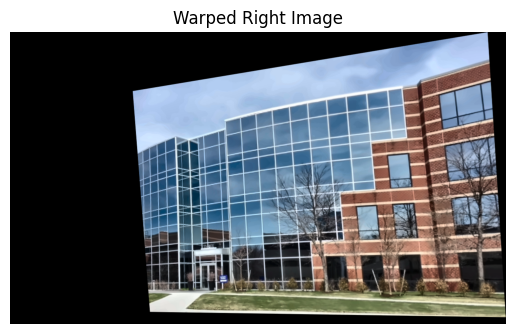

In [14]:
# Warp right image
print("[INFO] Warping right image...")
warpedR = cv2.warpPerspective(imgR_p, translate @ H, (panorama_w, panorama_h))
plt.figure()
plt.imshow(cv2.cvtColor(warpedR, cv2.COLOR_BGR2RGB))
plt.title("Warped Right Image")
plt.axis("off")
plt.show()

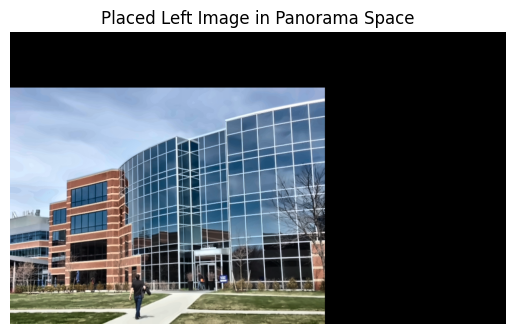

In [15]:
# Place left image
panorama = np.zeros_like(warpedR)
panorama[-y_min:hL - y_min, -x_min:wL - x_min] = imgL_p
plt.figure()
plt.imshow(cv2.cvtColor(panorama, cv2.COLOR_BGR2RGB))
plt.title("Placed Left Image in Panorama Space")
plt.axis("off")
plt.show()

In [16]:
# Blending
print("[INFO] Computing blending weights...")
maskL = np.zeros((panorama_h, panorama_w), dtype=np.float32)
maskL[-y_min:hL - y_min, -x_min:wL - x_min] = 1.0
maskR = (cv2.cvtColor(warpedR, cv2.COLOR_BGR2GRAY) > 0).astype(np.float32)

distL = cv2.distanceTransform((maskL==0).astype(np.uint8), cv2.DIST_L2, 3)
distR = cv2.distanceTransform((maskR==0).astype(np.uint8), cv2.DIST_L2, 3)
weightL = distL / (distL + distR + 1e-6)
weightR = 1.0 - weightL

[INFO] Computing blending weights...


In [17]:
print("[INFO] Blending images...")
blend = np.zeros_like(panorama, dtype=np.float32)
blend += (panorama.astype(np.float32) * weightL[...,None])
blend += (warpedR.astype(np.float32) * weightR[...,None])
blend = np.clip(blend, 0, 255).astype(np.uint8)

[INFO] Blending images...


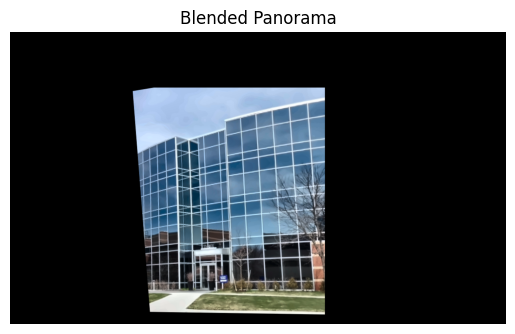

In [18]:
plt.figure()
plt.imshow(cv2.cvtColor(blend, cv2.COLOR_BGR2RGB))
plt.title("Blended Panorama")
plt.axis("off")
plt.show()

In [19]:
# Crop final panorama
print("[INFO] Cropping final panorama...")
gray = cv2.cvtColor(blend, cv2.COLOR_BGR2GRAY)
_, thresh = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
x,y,w,h = cv2.boundingRect(max(contours, key=cv2.contourArea))
stitched = blend[y:y+h, x:x+w]

[INFO] Cropping final panorama...


[INFO] Final stitched panorama saved as stitched_sift.jpg


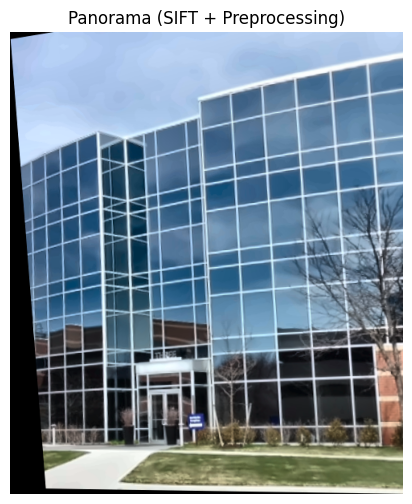

In [21]:
cv2.imwrite("stitched_sift.jpg", stitched)
print("[INFO] Final stitched panorama saved as stitched_sift.jpg")

plt.figure(figsize=(10,6))
plt.imshow(cv2.cvtColor(stitched, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Panorama (SIFT + Preprocessing)")
plt.show()